# Nueva versión MaximaMacro.jl ()

Una sola macro con paréntesis y comandos maxima entrecomillados.

**Sesión de una sola celda**  

✅ Ventajas de esta versión:

Nunca se bloquea: Maxima se cierra con quit().

Cada celda es independiente: no hay estado compartido.

No requiere gestión manual de sesiones.

Ideal para notebooks, informes diarios, o scripts simples.

⚠️ Limitaciones (y por qué son aceptables)

No conserva variables entre celdas: si defines a: 5$ en una celda, no existe en la siguiente.

→ Esto es deseable en muchos casos (reproducibilidad por celda).

Ligeramente más lento: inicia Maxima cada vez.

→ Pero Maxima arranca rápido, y para uso interactivo es imperceptible.

🔄 ¿Cuándo usar la versión persistente?
Solo si necesitas definir funciones, variables o estados complejos que se reutilicen en múltiples celdas.

Pero para la mayoría de los casos (especialmente en reportes o cálculos aislados), la versión por celda es más segura y simple.

### Sesión solo para una celda

**Los créditos de maxima se suprimen**

A no ser que utilicemos el parámetro creditos=true

In [1]:
module MaximaMacro


export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw = String(read(proc.out))
            wait(proc)
            for line in split(raw, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end
        else
            # ✅ Usar --quiet en lugar de --very-quiet
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw = String(read(proc.out))
            wait(proc)

            # Parsear resultados
            results = Dict{Int, String}()
            for line in split(raw, '\n')
                s = strip(line)
                # Buscar (%oN) incluso si hay espacios
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    val = m.captures[2]
                    # Ignorar (%o1) false de display2d
                    if n == 1 && val == "false"
                        continue
                    end
                    results[n] = line
                end
            end

            # Reconstruir salida limpia
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                println("(%i$(i)) $(cmd_clean);")
                if haskey(results, i + 1)
                    fixed = replace(results[i + 1], "(%o$(i+1))" => "(%o$(i))", count=1)
                    println(fixed)
                end
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3
(%i2) float(sqrt(2));
(%o2) 1.414213562373095
(%i3) solve(x^2 = 4, x);
(%o3) [x = -2,x = 2]


In [3]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%o2) x^3/3
(%i3) 
(%o3) 1.414213562373095
(%i4) 
(%o4) [x = -2,x = 2]
(%i5) 


**Versión con salida separada entre comandos**

En cada nueva versión reiniciar el kernel

In [1]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            println("Maxima 5.46.0 https://maxima.sourceforge.io")
            println("using Lisp GNU Common Lisp (GCL) GCL 2.6.14")
            println("Distributed under the GNU Public License. See the file COPYING.")
            println("Dedicated to the memory of William Schelter.")
            println()
        end

        proc = open(`maxima --quiet`, "r+")
        write(proc.in, "display2d:false\$\n")
        for cmd in $(user_cmds)
            write(proc.in, cmd * "\n")
        end
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        results = Dict{Int, String}()
        for line in split(raw, '\n')
            s = strip(line)
            m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
            if m !== nothing
                n = parse(Int, m.captures[1])
                val = m.captures[2]
                # Incluir (%o1) solo si no es el "false" de display2d
                if n == 1 && val == "false"
                    continue
                end
                results[n] = line
            end
        end

        # Mostrar display2d como primer comando si se piden créditos
        if $(creditos)
            println("(%i1) display2d:false\$")
            println("(%o1) false")
            println()
            offset = 1
        else
            offset = 0
        end

        for (i, cmd) in enumerate($(user_cmds))
            idx = i + offset
            cmd_clean = rstrip(strip(cmd), [';', '\$'])
            terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
            println("(%i$(idx)) $(cmd_clean)$(terminator)")
            if haskey(results, i + 1)
                # Ajustar número de salida
                out_line = results[i + 1]
                out_line_fixed = replace(out_line, "(%o$(i+1))" => "(%o$(idx))", count=1)
                println(out_line_fixed)
            end
            println()  # 🔹 Línea en blanco después de cada bloque
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.

(%i1) display2d:false$
(%o1) false

(%i2) integrate(x^2, x);
(%o2) x^3/3

(%i3) float(sqrt(2));
(%o3) 1.414213562373095

(%i4) solve(x^2 = 4, x);
(%o4) [x = -2,x = 2]



In [3]:
using .MaximaMacro
@maxima_session_cell(
    "load(qinf)",
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.



(%i1) display2d:false$
(%o1) false

(%i2) load(qinf);

(%i3) integrate(x^2, x);
(%o3) x^3/3

(%i4) float(sqrt(2));
(%o4) 1.414213562373095

(%i5) solve(x^2 = 4, x);
(%o5) [x = -2,x = 2]

(%i6) ket(1) + ket(2);
(%o6) ket(2)+ket(1)



**Por defecto cargar qinf**

Añadimos que se cargue la libreria  qinf si existe en el lugar en el que se busca por defecto: ~/.maxima 



In [1]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            println("Maxima 5.46.0 https://maxima.sourceforge.io")
            println("using Lisp GNU Common Lisp (GCL) GCL 2.6.14")
            println("Distributed under the GNU Public License. See the file COPYING.")
            println("Dedicated to the memory of William Schelter.")
            println()
        end

        # Comandos que SIEMPRE se envían a Maxima (silenciosos si creditos=false)
        proc = open(`maxima --quiet`, "r+")
        write(proc.in, "display2d:false\$\n")
        write(proc.in, "load(qinf)\$\n")
        for cmd in $(user_cmds)
            write(proc.in, cmd * "\n")
        end
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        # Parsear todas las salidas (%oN)
        results = Dict{Int, String}()
        for line in split(raw, '\n')
            s = strip(line)
            m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
            if m !== nothing
                n = parse(Int, m.captures[1])
                results[n] = line
            end
        end

        if $(creditos)
            # Mostrar TODO: display2d, load(qinf), y comandos del usuario
            output_lines = String[]

            # (%i1) display2d:false$
            push!(output_lines, "(%i1) display2d:false\$")
            push!(output_lines, haskey(results, 1) ? results[1] : "(%o1) false")
            push!(output_lines, "")

            # (%i2) load(qinf)$
            push!(output_lines, "(%i2) load(qinf)\$")
            push!(output_lines, haskey(results, 2) ? results[2] : "(%o2) false")
            push!(output_lines, "")

            # Comandos del usuario: empiezan en %i3
            for (i, cmd) in enumerate($(user_cmds))
                idx = 3 + i - 1
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                push!(output_lines, "(%i$(idx)) $(cmd_clean)$(terminator)")
                result_key = 3 + i - 1  # %o3, %o4, ...
                if haskey(results, result_key)
                    out_line = results[result_key]
                    out_line_fixed = replace(out_line, "(%o$(result_key))" => "(%o$(idx))", count=1)
                    push!(output_lines, out_line_fixed)
                end
                push!(output_lines, "")
            end

            for line in output_lines
                println(line)
            end

        else
            # Modo silencioso: omitir %i1 y %i2 (display2d y load(qinf))
            # Los comandos del usuario empiezan en %i1 visualmente
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = 3 + i - 1  # porque %o1 y %o2 ya usados
                if haskey(results, result_key)
                    out_line = results[result_key]
                    out_line_fixed = replace(out_line, "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(out_line_fixed)
                end
                println()  # línea en blanco
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_session_cell(
    "load(qinf)",
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.

(%i1) display2d:false$
(%o1) false

(%i2) load(qinf)$
(%o2) false

(%i3) load(qinf);

(%i4) integrate(x^2, x);
(%o4) x^3/3

(%i5) float(sqrt(2));
(%o5) 1.414213562373095

(%i6) solve(x^2 = 4, x);
(%o6) [x = -2,x = 2]

(%i7) ket(1) + ket(2);
(%o7) ket(2)+ket(1)



**Créditos reales, no "printados"**

In [1]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final (solo si es una asignación explícita)
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: usar Maxima sin --quiet para obtener cabecera real ──
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Imprimir toda la salida no vacía (incluye cabecera real y prompts)
            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: usar --quiet, ocultar setup, mostrar solo comandos del usuario ──
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los dos primeros comandos (%i1: display2d, %i2: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o3+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 2  # %o3, %o4, ...
                if haskey(results, result_key)
                    # Ajustar número de salida para que coincida con %iN visible
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%i3) 
(%o3) x^3/3
(%i4) 
(%o4) 1.414213562373095
(%i5) 
(%o5) [x = -2,x = 2]
(%i6) 
(%o6) matrix([3])
(%i7) 


**Sin créditos cargando automáticamente display2d:false y qinf**

Por defecto, Maxima muestra las expresiones matemáticas en un formato 2D que imita la escritura matemática tradicional, 

con fracciones, potencias, raíces, etc., visualmente más agradable y fácil de leer. Cuando se pone display2d:false, este 

formato se desactiva y la salida se muestra en una línea de texto simple, más adecuada para terminales sin soporte para 

formato avanzado o scripts automáticos.



In [1]:
module MaximaMacro

export @maxima_cell_session

macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: salida completa con cabecera real de Maxima ──
            proc = open(`maxima --disable-readline`, "r+")
            # Configurar salida 1D sin truncamiento:
            #   display2d:false → desactiva salida 2D (ASCII art)
            #   linel:32767     → límite de caracteres por línea (máximo permitido en Maxima)
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: ocultar configuración inicial y qinf ──
            proc = open(`maxima --quiet`, "r+")
            # Misma configuración, pero silenciosa
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los primeros 3 comandos (%i1: display2d, %i2: linel, %i3: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o4+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3  # %o4, %o5, ...
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)",
    "ket(1) + ket(2)"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(sqrt(2));
(%o2) 1.414213562373095

(%i3) solve(x^2 = 4, x);
(%o3) [x = -2,x = 2]

(%i4) ket(1) + ket(2);
(%o4) matrix([3])



In [3]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)",
    "ket(1) + ket(2)",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%i3) 
(%i4) 
(%o4) x^3/3
(%i5) 
(%o5) 1.414213562373095
(%i6) 
(%o6) [x = -2,x = 2]
(%i7) 
(%o7) matrix([3])
(%i8) 


No se estructura bien la  salida.

**Incluyendo funciones de evaluación de un comando maxima desde Julia**

Esto permite obtener en Julia directamente el resultado de un comando enviado a maxima.

Incluye dispay 1d y carga de qinf si existe. 

In [1]:
module MaximaMacro

export @maxima_cell_session, maxima_eval

"""
    maxima_eval(cmd::String)::String

Envía un único comando a Maxima y devuelve su resultado como cadena en formato 1D.
El comando se evalúa en un entorno limpio con:
  - display2d:false
  - linel:32767
  - qinf cargado (si está disponible)

Ejemplo:
    maxima_eval("integrate(x^2, x)")  →  "x^3/3"
    maxima_eval("float(%pi)")         →  "3.141592653589793"
"""
function maxima_eval(cmd::String)::String
    # Asegurar terminación
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    # Ejecutar Maxima en modo silencioso
    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)

    raw = String(read(proc.out))
    wait(proc)

    # Buscar la primera salida (%oN) después de los comandos iniciales
    # (%o1: display2d, %o2: linel, %o3: load(qinf), %o4: resultado del usuario)
    results = String[]
    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)  # El resultado del usuario es %o4
        if m !== nothing
            push!(results, m.captures[1])
        end
    end

    if length(results) == 0
        return ""  # sin resultado
    else
        return results[1]
    end
end

# ----------------------------
# Macro: @maxima_cell_session
# ----------------------------

macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: salida completa con cabecera real de Maxima ──
            proc = open(`maxima --disable-readline`, "r+")
            # Configurar salida 1D sin truncamiento:
            #   display2d:false → desactiva salida 2D (ASCII art)
            #   linel:32767     → límite de caracteres por línea (máximo permitido en Maxima)
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: ocultar configuración inicial y qinf ──
            proc = open(`maxima --quiet`, "r+")
            # Misma configuración, pero silenciosa
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los primeros 3 comandos (%i1: display2d, %i2: linel, %i3: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o4+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3  # %o4, %o5, ...
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro

# Resultado simbólico (cadena)
expr = maxima_eval("integrate(x^2, x)")
println(expr)  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str)  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1)  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result)  # → "matrix([1],[1])"  (ejemplo)

x^3/3
1.414213562373095
2.414213562373095
matrix([1])


# Generar gráficos de maxima en Julia  Jupyter


$sudo apt install gnuplot

Esta versión no me gusta, quiero que se aplique de manera automática

**No tiene un funcionamiento aceptable**

In [1]:
module MaximaMacro

using Base.Filesystem: mktemp
using Base: UUID
using Markdown

export @maxima_cell_session, maxima_eval, maxima_plot

# -------------------------------------------------
# maxima_eval: evalúa un comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)

    raw = String(read(proc.out))
    wait(proc)

    # El resultado del usuario es %o4
    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# maxima_plot: genera y muestra un gráfico en Jupyter
# -------------------------------------------------
"""
    maxima_plot(plot_cmd::String; format="png", width=600, height=400)

Ejecuta un comando de gráfico de Maxima (como `plot2d(...)`) y muestra el resultado en Jupyter.

Ejemplo:
    maxima_plot("plot2d(sin(x), [x, -%pi, %pi])")
"""
function maxima_plot(plot_cmd::String; format="png", width=600, height=400)
    if !occursin("plot2d", plot_cmd) && !occursin("plot3d", plot_cmd)
        error("El comando debe contener plot2d o plot3d")
    end

    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = tempname() * "." * format
    option_name = format * "_file"  # → "png_file", "svg_file", etc.

    try
        maxima_cmd = """
        display2d:false\$
        linel:32767\$
        load("qinf")\$
        $(cmd_clean), [$option_name, "$(tmpfile)"]\$
        """

        proc = open(`maxima --quiet`, "r+")
        write(proc.in, maxima_cmd)
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        if !isfile(tmpfile)
            @warn "Maxima no generó el archivo de gráfico. ¿Está Gnuplot instalado?"
            println("Salida de Maxima:\n", raw)
            return nothing
        end

        if format == "png"
            display("image/png", read(tmpfile))
        elseif format == "svg"
            display("image/svg+xml", read(tmpfile, String))
        else
            @info "Formato '$format' no soportado para visualización directa."
            @info "Archivo guardado temporalmente en: $tmpfile"
        end

    finally
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end

# -------------------------------------------------
# Macro: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2,x)", 
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

(%i1) integrate(x^2,x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) plot2d(sin(x), [x, -%pi, %pi]);
(%o3) false



**Otra versión intentanto que funcionen los gráficos**

Reiniciar el kernell

In [2]:
module MaximaMacro

using Base: tempname
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# Función auxiliar: ¿es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# maxima_eval (sin cambios esenciales)
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# maxima_plot_to_jupyter (interna)
# -------------------------------------------------
function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = "maxima_plot_temp.$format"
    macfile = tempname() * ".mac"

    # Asegurar limpieza previa
    isfile(tmpfile) && rm(tmpfile)

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    load("qinf")\$
    gnuplot_term: "$(format) size 800,600"\$
    gnuplot_out_file: "$(tmpfile)"\$
    $(cmd_clean)\$
    gnuplot_out_file: false\$
    """

    write(macfile, mac_content)

    env = copy(ENV)
    env["GNUTERM"] = format

    try
        run(setenv(`maxima --quiet --batch=$macfile`, env))

        if !isfile(tmpfile) || filesize(tmpfile) == 0
            println("❌ No se generó el gráfico.")
            return false
        end

        # Leer y mostrar
        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        # Guardar copia permanente
        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        # NO borrar tmpfile aquí — Jupyter ya lo leyó
    end

    # Borrar tmpfile después de display
    isfile(tmpfile) && rm(tmpfile, force=true)
end

# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Verificar si hay comandos gráficos
    plot_indices = Int[]
    for (i, cmd) in enumerate(user_cmds)
        if is_plot_command(cmd)
            push!(plot_indices, i)
        end
    end

    if !isempty(plot_indices)
        # Modo gráfico: procesar cada comando gráfico
        quote
            # Si hay modo créditos, advertir que no se aplica a gráficos
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora para comandos gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    println("🎨 Generando gráfico $(i): $(cmd)")
                    _maxima_plot_to_jupyter(cmd)
                    println()  # línea en blanco
                else
                    # Comando no gráfico: usar maxima_eval y mostrar
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # Modo texto habitual (sin gráficos)
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end

            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2,x)", 
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

(%i1) integrate(x^2,x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

🎨 Generando gráfico 3: plot2d(sin(x), [x, -%pi, %pi]);

(%i1) batch("/tmp/jl_qNapiJQ5a5.mac")

read and interpret /tmp/jl_qNapiJQ5a5.mac
(%i2) kill(all)
(%i1) display2d:false
(%i2) linel:32767
(%i3) load("qinf")
(%i4) gnuplot_term:"png size 800,600"
(%i5) gnuplot_out_file:"maxima_plot_temp.png"
(%i6) plot2d(sin(x),[x,-%pi,%pi])
(%i7) gnuplot_out_file:false
(%o8) "/tmp/jl_qNapiJQ5a5.mac"
❌ No se generó el gráfico.



base64 binary data: iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAIAAAC6s0uzAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAgAElEQVR4nO3dfXBU1f3H8e8CYQwxmIY4FXGAn40ILVIsKQ8+QEgRcdR0bCeZVpGBtoKlDtU0dSgyDRlb7VBs1cpUMm21GRsxO+MgzrQaIQ9Ky0NJwACBselMKCpogNJojDWa/f2x22Qhye5ms/ecc895v4Y/kiUPJ7v37ud+v+fcewOhUEgAAIBaI3QPAAAAFxHAAABoQAADAKABAQwAgAYEMAAAGhDAAABoQAADAKABAQwAgAYEMAAAGhDAAABoQAADAKABAQwAgAYEMAAAGhDAAABoQAADAKABAQwAgAYEMAAAGhDAAABoQAADAKABAQwAgAYEMAAAGhDAAABoQAADAKABAQwAgAYEMAAAGhDAAABoMEr3AEwRCAR0DwEAYIpQKOT1ryCA+8R9ugOBgIKXxDRu/tXi6h/OX+0UN//wRP5qNSUZLWgAADQggAEA0IAABgBAAxcnAAbk5lwIAKA/NYlABQwAgAYEMIA+nI8HKEMAAwCgAQEMoA8rIQBlCGAAADSwLYB37ty5YsWKSy65JBAIHD9+XPdwAJ9hDhhQxqoA3r179yOPPDJ//vzS0lLdYwEAIBarAnjevHnhCnjs2LG6xwL4EnPAgDJWBTAAAH5BAAPowxwwoAwBDACABgQwgD7MAQPKEMB9AlF0jwWA/crLJRAYwj94Sn0EEMB9QlF0jwXQg6NPT12QuKHQ0P4Rxp5SHwEEMAB4Lhy9FwTqhg1D+yEDhjH8iwAG0If2T8pFR+9QEzeGC5IYfmRVAH/22Wfh9v39998vIpMnTw4EArfffrvucQFwTjAoxcWeRO8FomO4vNyr3wIvWBXAI0eODPXz8ssv6x4X4BvMAQ9fuOQNBqWoyNvojUZB7EdWBTAAaBTdba6ulqIi1QPYsKEvhmG+



**Nueva versión intentando que salgan los gráficos**

Reiniciar kernel





In [1]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# Genera y muestra gráfico en Jupyter + guarda en ./plots/
# -------------------------------------------------

function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = joinpath(pwd(), "maxima_plot_temp.$format")
    macfile = tempname() * ".mac"

    isfile(tmpfile) && rm(tmpfile)

    # Reconstruir comando con opciones integradas
    if endswith(cmd_clean, ")")
        plot_with_opts = cmd_clean[1:end-1] *
                         ", [gnuplot_term, $format], " *
                         "[gnuplot_out_file, \"$(tmpfile)\"])"
    else
        plot_with_opts = cmd_clean
    end

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    ignore(load("qinf"))\$
    gnuplot_pipes: true\$
    $plot_with_opts\$
    """

    write(macfile, mac_content)

    try
        # ✅ Suprimir salida de Maxima
        run(pipeline(`maxima --quiet --batch=$macfile`, stderr=devnull, stdout=devnull))

        # Espera activa
        max_wait = 2.0
        check_interval = 0.1
        elapsed = 0.0
        file_ready = false
        while elapsed < max_wait
            if isfile(tmpfile) && filesize(tmpfile) > 0
                file_ready = true
                break
            end
            sleep(check_interval)
            elapsed += check_interval
        end

        if !file_ready
            println("❌ No se generó el gráfico.")
            return false
        end

        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end
# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo híbrido: procesar comandos uno a uno ──
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    println("🎨 Generando gráfico $(i): $(cmd)")
                    $(Symbol("_maxima_plot_to_jupyter"))(cmd)
                    println()
                else
                    # Comando no gráfico: evaluar y mostrar
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # ── Modo texto puro ──
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end
            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

🎨 Generando gráfico 1: 
    plot2d(sin(x), [x, -%pi, %pi]);



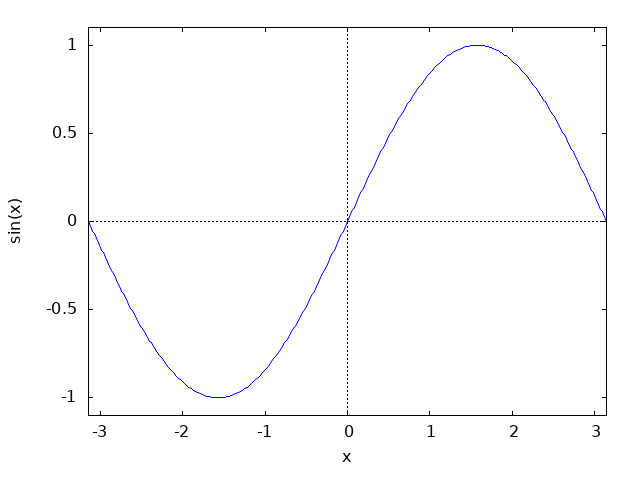

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_12_19T20_21_24_310.png



In [2]:
using .MaximaMacro
@maxima_cell_session "
    plot2d(sin(x), [x, -%pi, %pi]);
"

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

🎨 Generando gráfico 3: plot2d(sin(x), [x, -%pi, %pi]);


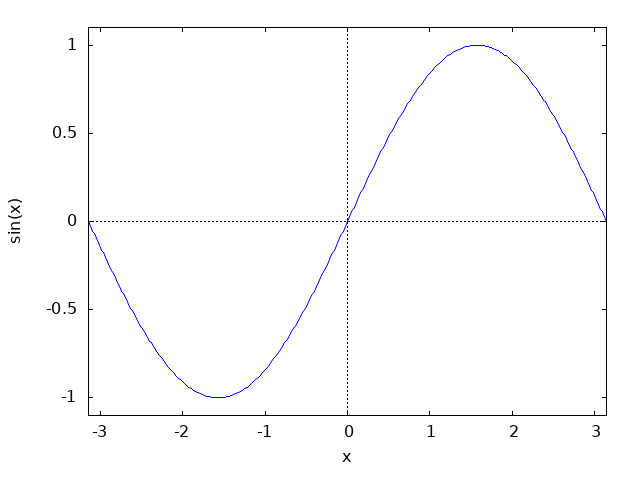

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_12_19T20_21_27_197.png



In [3]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

**Quito avisos y solo presento gráfico**

In [2]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# Genera y muestra gráfico en Jupyter + guarda en ./plots/
# -------------------------------------------------

function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = joinpath(pwd(), "maxima_plot_temp.$format")
    macfile = tempname() * ".mac"

    isfile(tmpfile) && rm(tmpfile)

    # Reconstruir comando con opciones integradas
    if endswith(cmd_clean, ")")
        plot_with_opts = cmd_clean[1:end-1] *
                         ", [gnuplot_term, $format], " *
                         "[gnuplot_out_file, \"$(tmpfile)\"])"
    else
        plot_with_opts = cmd_clean
    end

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    ignore(load("qinf"))\$
    gnuplot_pipes: true\$
    $plot_with_opts\$
    """

    write(macfile, mac_content)

    try
        # ✅ Suprimir salida de Maxima
        run(pipeline(`maxima --quiet --batch=$macfile`, stderr=devnull, stdout=devnull))

        # Espera activa
        max_wait = 2.0
        check_interval = 0.1
        elapsed = 0.0
        file_ready = false
        while elapsed < max_wait
            if isfile(tmpfile) && filesize(tmpfile) > 0
                file_ready = true
                break
            end
            sleep(check_interval)
            elapsed += check_interval
        end

        if !file_ready
            println("❌ No se generó el gráfico.")
            return false
        end

        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end
# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo híbrido: procesar comandos uno a uno ──
        # Dentro del bloque `if has_plot`
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    # Mostrar entrada como (%iN) comando;
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    # Mostrar la línea de salida textual
                    println("(%o$(i)) gráfico:")
                    println()  # línea en blanco opcional
                    
                    # Generar y mostrar gráfico (sin mensaje extra)
                    success = $(Symbol("_maxima_plot_to_jupyter"))(cmd)
                    if !success
                        println("(%o$(i)) error al generar gráfico")
                        println()
                    end
                else
                    # Comando no gráfico (sin cambios)
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # ── Modo texto puro ──
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end
            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

In [3]:
using .MaximaMacro
@maxima_cell_session(
    "h(x):=x^2",
    "h(2)",
    "is(h(x) = h(-x))"
)

(%i1) h(x):=x^2;
(%o1) h(x):=x^2

(%i2) h(2);
(%o2) 4

(%i3) is(h(x) = h(-x));
(%o3) true



(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) plot2d(sin(x), [x, -%pi, %pi]);
(%o3) gráfico:



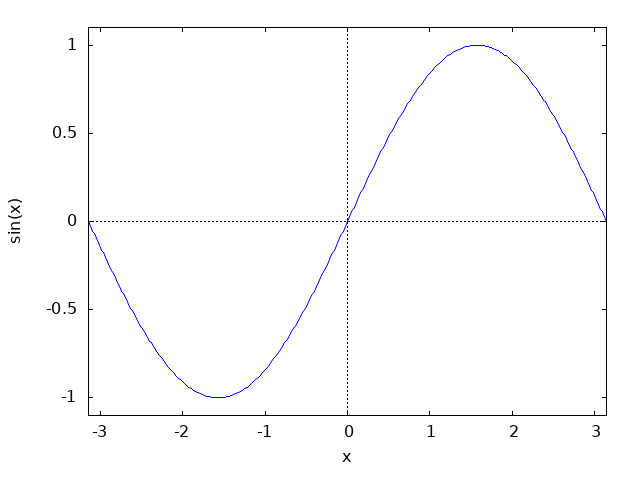

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_12_19T20_21_48_980.png


In [4]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.
(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) plot2d(sin(x), [x, -%pi, %pi]);
(%o3) gráfico:



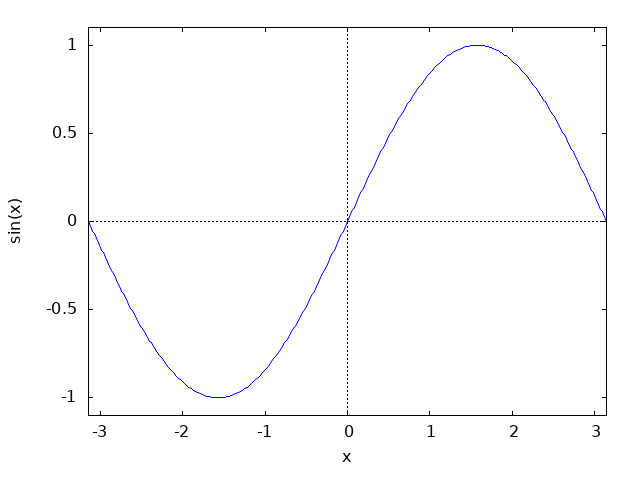

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_12_19T20_21_53_673.png


In [5]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])",
    creditos=true
)

In [6]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    creditos=true
    
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%i3) 
(%i4) 
(%o4) x^3/3
(%i5) 
(%o5) 3.141592653589793
(%i6) 


**Cambiamos la salida con créditos**

In [2]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# Genera y muestra gráfico en Jupyter + guarda en ./plots/
# -------------------------------------------------

function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = joinpath(pwd(), "maxima_plot_temp.$format")
    macfile = tempname() * ".mac"

    isfile(tmpfile) && rm(tmpfile)

    # Reconstruir comando con opciones integradas
    if endswith(cmd_clean, ")")
        plot_with_opts = cmd_clean[1:end-1] *
                         ", [gnuplot_term, $format], " *
                         "[gnuplot_out_file, \"$(tmpfile)\"])"
    else
        plot_with_opts = cmd_clean
    end

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    ignore(load("qinf"))\$
    gnuplot_pipes: true\$
    $plot_with_opts\$
    """

    write(macfile, mac_content)

    try
        # ✅ Suprimir salida de Maxima
        run(pipeline(`maxima --quiet --batch=$macfile`, stderr=devnull, stdout=devnull))

        # Espera activa
        max_wait = 2.0
        check_interval = 0.1
        elapsed = 0.0
        file_ready = false
        while elapsed < max_wait
            if isfile(tmpfile) && filesize(tmpfile) > 0
                file_ready = true
                break
            end
            sleep(check_interval)
            elapsed += check_interval
        end

        if !file_ready
            println("❌ No se generó el gráfico.")
            return false
        end

        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end
# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo híbrido: procesar comandos uno a uno ──
        # Dentro del bloque `if has_plot`
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    # Mostrar entrada como (%iN) comando;
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    # Mostrar la línea de salida textual
                    println("(%o$(i)) gráfico:")
                    println()  # línea en blanco opcional
                    
                    # Generar y mostrar gráfico (sin mensaje extra)
                    success = $(Symbol("_maxima_plot_to_jupyter"))(cmd)
                    if !success
                        println("(%o$(i)) error al generar gráfico")
                        println()
                    end
                else
                    # Comando no gráfico (sin cambios)
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
    # ── Modo texto puro UNIFICADO con créditos reales ──
    quote
        cmds = $(user_cmds)

        # Mostrar créditos reales si se pide
        if $(creditos)
            # Ejecutar Maxima sin --quiet solo para obtener el encabezado
            proc_credit = open(`maxima --batch-string="quit();"`, "r")
            credit_lines = String(read(proc_credit.out))
            wait(proc_credit)

            # Mostrar solo las líneas antes de la primera entrada (%i1)
            printed = false
            for line in split(credit_lines, '\n')
                s = rstrip(line)
                # Detenerse al encontrar la primera línea de entrada
                if occursin(r"%i\d+", s)
                    break
                end
                if !printed && s == ""
                    continue  # omitir líneas vacías iniciales
                end
                println(s)
                printed = true
            end
            println()  # línea en blanco antes de los comandos
        end

        # Ejecutar comandos en modo quiet (siempre)
        proc = open(`maxima --quiet`, "r+")
        write(proc.in, "display2d:false\$\n")
        write(proc.in, "linel:32767\$\n")
        write(proc.in, "ignore(load(\"qinf\"))\$\n")
        for cmd in cmds
            write(proc.in, cmd * "\n")
        end
        close(proc.in)
        raw_output = String(read(proc.out))
        wait(proc)

        # Extraer resultados (%oN)
        results = Dict{Int, String}()
        for line in split(raw_output, '\n')
            s = strip(line)
            m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
            if m !== nothing
                n = parse(Int, m.captures[1])
                results[n] = m.captures[2]
            end
        end

        # Mostrar salida limpia
        for (i, cmd) in enumerate(cmds)
            cmd_clean = rstrip(strip(cmd), [';', '\$'])
            terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
            println("(%i$(i)) $(cmd_clean)$(terminator)")
            result_key = i + 3
            if haskey(results, result_key)
                println("(%o$(i)) $(results[result_key])")
            end
            println()
        end
    end
end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    creditos=true
    
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793



**Con créditos y sin gráficos**

In [3]:
using .MaximaMacro

# Resultado simbólico (cadena)
comando="integrate(x^2, x)"
expr = maxima_eval(comando)
println(comando ,"  -->  ", expr,"\n")  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str,"\n")  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1,"\n")  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result,"\n")  # → "matrix([1],[1])"  (ejemplo)

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "a:5",
    "b:10",
    "c:a + b",
    creditos=true
)

integrate(x^2, x)  -->  x^3/3

1.414213562373095

2.414213562373095

matrix([1])

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) a:5;
(%o3) 5

(%i4) b:10;
(%o4) 10

(%i5) c:a + b;
(%o5) 15



(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) b+a

(%i4) plot2d(sin(x), [x, 0, %pi]);
(%o4) gráfico:



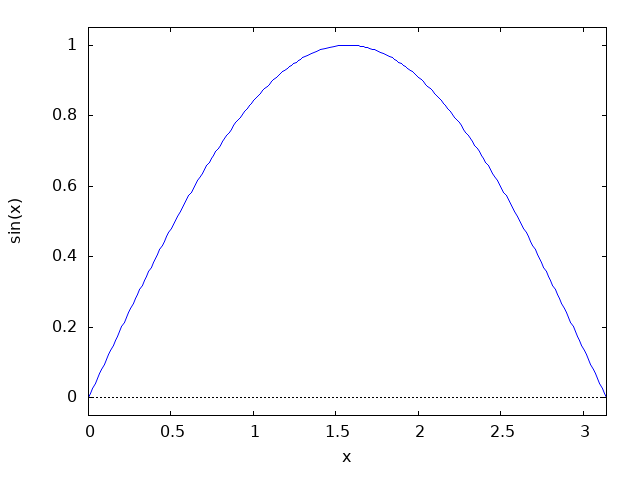

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_12_19T20_22_53_106.png


In [4]:
using .MaximaMacro

# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    "plot2d(sin(x), [x, 0, %pi])"
)

**Si meto gráficos se pierde la sesión**

In [5]:
@maxima_cell_session(
    "integrate(x^2, x);",
    "a:float(%pi);",
    "b:a+1;",
    creditos = true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) a:float(%pi);
(%o2) 3.141592653589793

(%i3) b:a+1;
(%o3) 4.141592653589793



**Verión sin perdida de sesión con gráficos**

In [1]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, @maxima, maxima_eval

macro maxima(expr)
    cmd = replace(string(expr), "\"" => "\\\"")
    print(read(`maxima --very-quiet --batch-string="$cmd;"`, String))
end


# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end


# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo con gráficos: sesión única + post-procesamiento ──
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            processed_cmds = String[]
            plot_indices = Int[]

            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    cmd_clean = strip(replace(cmd, r"[;\$]$" => ""))
                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    if endswith(cmd_clean, ")")
                        new_cmd = cmd_clean[1:end-1] *
                                  ", [gnuplot_term, png], " *
                                  "[gnuplot_out_file, \"$(tmpfile)\"])"
                    else
                        new_cmd = cmd_clean
                    end
                    push!(processed_cmds, new_cmd * ";")
                    push!(plot_indices, i)
                else
                    push!(processed_cmds, cmd)
                end
            end

            # Ejecutar toda la sesión en un solo proceso
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            write(proc.in, "gnuplot_pipes: true\$\n")
            for cmd in processed_cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Extraer resultados (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            # Mostrar salida en orden
            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")

                if $(is_plot_command)(cmd)
                    println("(%o$(i)) gráfico:")
                    println()
                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    if isfile(tmpfile) && filesize(tmpfile) > 0
                        img_data = read(tmpfile)
                        display(MIME("image/png"), img_data)
                        # Guardar copia silenciosa
                        plot_dir = joinpath(pwd(), "plots")
                        mkpath(plot_dir)
                        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
                        permanent_path = joinpath(plot_dir, "plot_$(timestamp)_$(i).png")
                        write(permanent_path, img_data)
                        isfile(tmpfile) && rm(tmpfile, force=true)
                    end
                else
                    # 4 comandos iniciales: display2d, linel, load, gnuplot_pipes
                    result_key = i + 4
                    if haskey(results, result_key)
                        println("(%o$(i)) $(results[result_key])")
                    end
                    println()
                end
            end
        end
    else
        # ── Modo sin gráficos: sesión única y limpia ──
        quote
            cmds = $(user_cmds)

            if $(creditos)
                # Obtener créditos reales
                proc_credit = open(`maxima --batch-string="quit();"`, "r")
                credit_lines = String(read(proc_credit.out))
                wait(proc_credit)

                printed = false
                for line in split(credit_lines, '\n')
                    s = rstrip(line)
                    if occursin(r"%i\d+", s)
                        break
                    end
                    if !printed && s == ""
                        continue
                    end
                    println(s)
                    printed = true
                end
                println()
            end

            # Ejecutar comandos
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            for cmd in cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3  # 3 comandos iniciales
                if haskey(results, result_key)
                    println("(%o$(i)) $(results[result_key])")
                end
                println()
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro

In [3]:
# Resultado simbólico (cadena)
comando="integrate(x^2, x)"
expr = maxima_eval(comando)
println(comando ,"  -->  ", expr,"\n")  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str,"\n")  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1,"\n")  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result,"\n")  # → "matrix([1],[1])"  (ejemplo)



integrate(x^2, x)  -->  x^3/3

1.414213562373095

2.414213562373095

matrix([1])



In [4]:
@maxima "integrate(x^2, x)"

@maxima "f(x) := x^3 - 3*x + 2"


integrate(x^2,x)
                                       3
                                      x
                                      --
                                      3

f(x):=x^3-3*x+2
                                      3
                             f(x) := x  - 3 x + 2


In [5]:
@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "a:5",
    "b:10",
    "c:a + b"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) a:5;
(%o3) 5

(%i4) b:10;
(%o4) 10

(%i5) c:a + b;
(%o5) 15



In [6]:
using .MaximaMacro

# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12



(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12

(%i4) plot2d(sin(x), [x, 0, %pi]);
(%o4) gráfico:



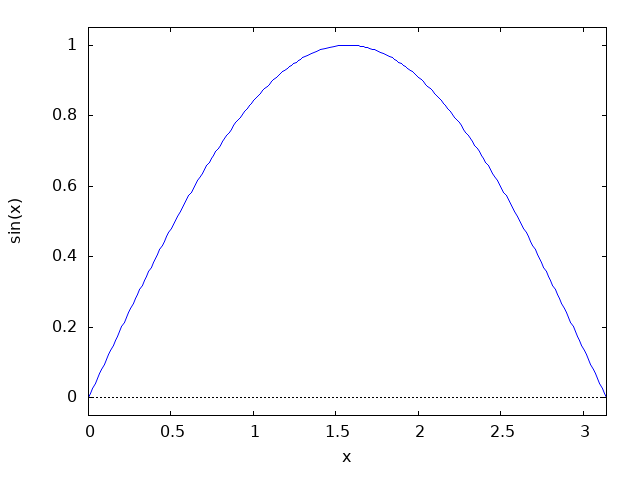

In [7]:
using .MaximaMacro

# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    "plot2d(sin(x), [x, 0, %pi])"
)

**Resultados a fichero de texto**  --> no funciona, revisar

https://chat.qwen.ai/c/c9571681-83cc-445a-95d1-cc1a8f52e3d1

In [1]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, @maxima, maxima_eval

macro maxima(expr)
    cmd = replace(string(expr), "\"" => "\\\"")
    print(read(`maxima --very-quiet --batch-string="$cmd;"`, String))
end

function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    fichero = nothing
    cmds_list = Any[exs...]

    # Detectar creditos=true
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Detectar fichero="nombre.txt"
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :fichero
            val = last_arg.args[2]
            if val isa String
                fichero = val
            elseif val isa Expr && val.head === :string
                str_repr = sprint(show, val)
                if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                    fichero = str_repr[2:end-1]
                else
                    error("Nombre de fichero no válido")
                end
            else
                error("El argumento 'fichero' debe ser una cadena")
            end
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        quote
            # Mostrar créditos si se piden (solo como aviso)
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            processed_cmds = String[]
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    cmd_clean = strip(replace(cmd, r"[;\$]$" => ""))
                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    if endswith(cmd_clean, ")")
                        new_cmd = cmd_clean[1:end-1] *
                                  ", [gnuplot_term, png], " *
                                  "[gnuplot_out_file, \"$(tmpfile)\"])"
                    else
                        new_cmd = cmd_clean
                    end
                    push!(processed_cmds, new_cmd * ";")
                else
                    push!(processed_cmds, cmd)
                end
            end

            # Ejecutar toda la sesión
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            write(proc.in, "gnuplot_pipes: true\$\n")
            for cmd in processed_cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Procesar resultados no gráficos
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            # Salida en tiempo real (para mantener el orden en Jupyter)
            output_lines = String[]

            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                line_i = "(%i$(i)) $(cmd_clean)$(terminator)"
                println(line_i)
                push!(output_lines, line_i)

                if $(is_plot_command)(cmd)
                    line_o = "(%o$(i)) gráfico:"
                    println(line_o)
                    println()
                    push!(output_lines, line_o)
                    push!(output_lines, "")

                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    permanent_path = ""
                    if isfile(tmpfile) && filesize(tmpfile) > 0
                        img_data = read(tmpfile)
                        display(MIME("image/png"), img_data)  # ← AQUÍ se muestra en su sitio
                        plot_dir = joinpath(pwd(), "plots")
                        mkpath(plot_dir)
                        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
                        permanent_path = joinpath(plot_dir, "plot_$(timestamp)_$(i).png")
                        write(permanent_path, img_data)
                        isfile(tmpfile) && rm(tmpfile, force=true)
                    end

                    if $(fichero !== nothing) && permanent_path != ""
                        rel_path = replace(permanent_path, pwd() * "/" => "./")
                        path_line = "→ Guardado en: $(rel_path)"
                        push!(output_lines, path_line)
                    end
                else
                    result_key = i + 4
                    if haskey(results, result_key)
                        res_line = "(%o$(i)) $(results[result_key])"
                        println(res_line)
                        push!(output_lines, res_line)
                    end
                    println()
                    push!(output_lines, "")
                end
            end

            # Guardar en fichero si se pide
            if $(fichero !== nothing)
                output_text = join(output_lines, "\n") * "\n"
                write($(Meta.quot(fichero)), output_text)
            end
            nothing
        end
    else
        quote
            cmds = $(user_cmds)
            output_lines = String[]

            if $(creditos)
                proc_credit = open(`maxima --batch-string="quit();"`, "r")
                credit_lines = String(read(proc_credit.out))
                wait(proc_credit)

                printed = false
                for line in split(credit_lines, '\n')
                    s = rstrip(line)
                    if occursin(r"%i\d+", s)
                        break
                    end
                    if !printed && s == ""
                        continue
                    end
                    println(s)
                    push!(output_lines, s)
                    printed = true
                end
                println()
                push!(output_lines, "")
            end

            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            for cmd in cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                line_i = "(%i$(i)) $(cmd_clean)$(terminator)"
                println(line_i)
                push!(output_lines, line_i)

                result_key = i + 3
                if haskey(results, result_key)
                    res_line = "(%o$(i)) $(results[result_key])"
                    println(res_line)
                    push!(output_lines, res_line)
                end
                println()
                push!(output_lines, "")
            end

            if $(fichero !== nothing)
                output_text = join(output_lines, "\n") * "\n"
                write($(Meta.quot(fichero)), output_text)
            end
            nothing
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro

In [3]:
# Resultado simbólico (cadena)
comando="integrate(x^2, x)"
expr = maxima_eval(comando)
println(comando ,"  -->  ", expr,"\n")  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str,"\n")  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1,"\n")  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result,"\n")  # → "matrix([1],[1])"  (ejemplo)


integrate(x^2, x)  -->  x^3/3

1.414213562373095

2.414213562373095

matrix([1])



In [4]:
@maxima "integrate(x^2, x)"

@maxima "f(x) := x^3 - 3*x + 2"


integrate(x^2,x)
                                       3
                                      x
                                      --
                                      3

f(x):=x^3-3*x+2
                                      3
                             f(x) := x  - 3 x + 2


In [5]:
@maxima_cell_session(
    "integrate(x^2, x)",
    "pi:float(%pi)",
    "pi+1",
    "a:5",
    "b:10",
    "c:a + b"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) pi:float(%pi);
(%o2) 3.141592653589793

(%i3) pi+1;
(%o3) 4.141592653589793

(%i4) a:5;
(%o4) 5

(%i5) b:10;
(%o5) 10

(%i6) c:a + b;
(%o6) 15



In [6]:
using .MaximaMacro

# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12



(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12

(%i4) plot2d(sin(x), [x, 0, %pi]);
(%o4) gráfico:



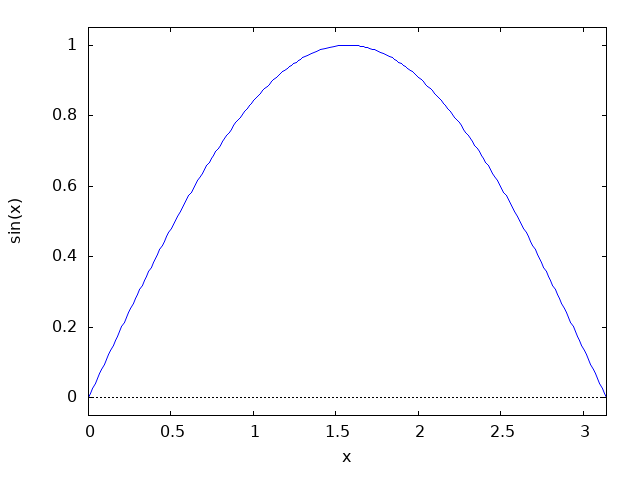

In [7]:
using .MaximaMacro

# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    "plot2d(sin(x), [x, 0, %pi])"
)

**Cómo son las asignaciones, funciones y ecuaciones en maxima:**

<img src="./images/asignacionMaxima.PNG" />

# Ventajas de esta versión respecto a la anterior

Julia interpreta todo lo escrito y ciertos símbolos los interpreta. 

Por ello deberíamos cambiar : por = y eso cambia la sintaxis de maxima, con lo que luego deberiamos 

cambiar esos signos para que coincida con la sintaxis maxima.  

También hay problemas con los puntos cuando actuan como producto en las operaciones utilizando qinf. 

Esta nueva versión evita cualquier tipo de problema para ejecutar cualquier comando maxima en su sintaxis. 

Encerrar en dobles comillas es más engorroso pero mucho más seguro. 



# Subida a github 

Ver si puedo hacer una rama o si elimino la versión anterior

decida lo que decida aquí tengo la forma de hacerlo. 

https://chat.qwen.ai/c/c9571681-83cc-445a-95d1-cc1a8f52e3d1

Con la estructura necesaria

Hacer una prueba de release con algo básico para probar y luego hacerla con la última versión. 

**Comprobar esta versión recomenda y ponerla en maximamacro2.jl



In [1]:
# ------------------------------------------------------------
# Módulo MaximaMacro.jl
# Interfaz avanzada entre Julia y Maxima para entornos como Jupyter
# Permite ejecutar comandos de Maxima con sesión persistente,
# salida limpia, gráficos integrados y opciones de exportación.
# ------------------------------------------------------------

module MaximaMacro

# Dependencias del módulo estándar de Julia
using Base: tempname      # Genera nombres de archivos temporales únicos
using Dates               # Para marcar fecha/hora en los nombres de gráficos
import Base.display       # Permitir mostrar gráficos en Jupyter

# Exportar las funciones/macro que el usuario podrá usar
export @maxima_cell_session, @maxima, maxima_eval

# ------------------------------------------------------------
# Macro simple: @maxima
# Ejecuta un solo comando de Maxima y muestra la salida cruda.
# Útil para pruebas rápidas.
# ------------------------------------------------------------
macro maxima(expr)
    # Convertir la expresión a cadena y escapar comillas
    cmd = replace(string(expr), "\"" => "\\\"")
    # Ejecutar Maxima en modo muy silencioso y mostrar resultado
    print(read(`maxima --very-quiet --batch-string="$cmd;"`, String))
end

# ------------------------------------------------------------
# Función: maxima_eval
# Evalúa un único comando de Maxima y devuelve solo el resultado (como cadena).
# Útil para uso programático (no desde la macro principal).
# ------------------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    # Asegurar que el comando termine en ; o $
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    # Abrir proceso de Maxima en modo interactivo (pero sin salida de inicio)
    proc = open(`maxima --quiet`, "r+")
    # Configurar entorno: salida 1D, líneas largas, cargar qinf si existe
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")  # No fallar si no existe
    write(proc.in, cmd * "\n")
    close(proc.in)  # Cerrar entrada para que Maxima termine
    raw = String(read(proc.out))  # Leer toda la salida
    wait(proc)  # Esperar a que el proceso termine

    # Buscar la línea (%o4) que contiene el resultado del cuarto comando
    # (los tres primeros son configuración)
    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# ------------------------------------------------------------
# Función auxiliar: is_plot_command
# Detecta si un comando es gráfico (plot2d, plot3d, etc.)
# ------------------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    # Lista de palabras clave que indican un comando gráfico
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# ------------------------------------------------------------
# Macro principal: @maxima_cell_session
# Permite ejecutar múltiples comandos en una sola sesión de Maxima,
# manteniendo el estado entre ellos (variables, funciones, etc.).
# Soporta gráficos, créditos reales y guardado en fichero.
# ------------------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    # Variables para opciones opcionales
    creditos = false   # ¿Mostrar créditos de Maxima?
    fichero = nothing  # ¿Guardar salida en un fichero de texto?
    cmds_list = Any[exs...]  # Lista de argumentos

    # --------------------------------------------------------
    # Detectar si el último argumento es creditos=true
    # --------------------------------------------------------
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)  # Eliminar de la lista de comandos
        end
    end

    # --------------------------------------------------------
    # Detectar si el último argumento es fichero="nombre.txt"
    # --------------------------------------------------------
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :fichero
            val = last_arg.args[2]
            if val isa String
                fichero = val
            elseif val isa Expr && val.head === :string
                # Extraer cadena de una expresión de cadena
                str_repr = sprint(show, val)
                if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                    fichero = str_repr[2:end-1]
                else
                    error("Nombre de fichero no válido")
                end
            else
                error("El argumento 'fichero' debe ser una cadena")
            end
            pop!(cmds_list)  # Eliminar de la lista de comandos
        end
    end

    # --------------------------------------------------------
    # Validar y preparar los comandos del usuario
    # --------------------------------------------------------
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            # Convertir expresión de cadena a cadena real
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        # Asegurar que cada comando termine en ; o $
        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # --------------------------------------------------------
    # ¿Hay algún comando gráfico?
    # --------------------------------------------------------
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    # --------------------------------------------------------
    # Modo con gráficos: procesar todos los comandos en una sola sesión
    # --------------------------------------------------------
    if has_plot
        quote
            # ----------------------------------------------------
            # Mostrar aviso si se piden créditos (no compatibles con gráficos)
            # ----------------------------------------------------
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            processed_cmds = String[]  # Comandos adaptados para Maxima

            # ----------------------------------------------------
            # Preprocesar comandos: convertir plot2d en versión con salida a archivo
            # ----------------------------------------------------
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    cmd_clean = strip(replace(cmd, r"[;\$]$" => ""))
                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    # Añadir opciones de Gnuplot directamente en el comando
                    if endswith(cmd_clean, ")")
                        new_cmd = cmd_clean[1:end-1] *
                                  ", [gnuplot_term, png], " *
                                  "[gnuplot_out_file, \"$(tmpfile)\"])"
                    else
                        new_cmd = cmd_clean
                    end
                    push!(processed_cmds, new_cmd * ";")
                else
                    push!(processed_cmds, cmd)
                end
            end

            # ----------------------------------------------------
            # Ejecutar todos los comandos en una sola sesión de Maxima
            # ----------------------------------------------------
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            write(proc.in, "gnuplot_pipes: true\$\n")  # Necesario para gráficos en batch
            for cmd in processed_cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # ----------------------------------------------------
            # Extraer resultados no gráficos (%oN)
            # ----------------------------------------------------
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            # ----------------------------------------------------
            # Mostrar salida en tiempo real (para mantener orden en Jupyter)
            # y preparar contenido para fichero
            # ----------------------------------------------------
            output_lines = String[]

            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                line_i = "(%i$(i)) $(cmd_clean)$(terminator)"
                println(line_i)
                push!(output_lines, line_i)

                if $(is_plot_command)(cmd)
                    # Mostrar línea de salida para gráfico
                    line_o = "(%o$(i)) gráfico:"
                    println(line_o)
                    println()
                    push!(output_lines, line_o)
                    push!(output_lines, "")

                    # ------------------------------------------------
                    # Mostrar gráfico en Jupyter y guardar copia
                    # ------------------------------------------------
                    tmpfile = joinpath(pwd(), "maxima_plot_temp_$(i).png")
                    permanent_path = ""
                    if isfile(tmpfile) && filesize(tmpfile) > 0
                        img_data = read(tmpfile)
                        display(MIME("image/png"), img_data)  # ← AQUÍ se muestra en su sitio
                        plot_dir = joinpath(pwd(), "plots")
                        mkpath(plot_dir)
                        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
                        permanent_path = joinpath(plot_dir, "plot_$(timestamp)_$(i).png")
                        write(permanent_path, img_data)
                        isfile(tmpfile) && rm(tmpfile, force=true)
                    end

                    # Añadir ruta al fichero de salida (solo si se pide)
                    if $(fichero !== nothing) && permanent_path != ""
                        rel_path = replace(permanent_path, pwd() * "/" => "./")
                        path_line = "→ Guardado en: $(rel_path)"
                        push!(output_lines, path_line)
                    end
                else
                    # Mostrar resultado no gráfico
                    result_key = i + 4  # 4 comandos de inicialización
                    if haskey(results, result_key)
                        res_line = "(%o$(i)) $(results[result_key])"
                        println(res_line)
                        push!(output_lines, res_line)
                    end
                    println()
                    push!(output_lines, "")
                end
            end

            # ----------------------------------------------------
            # Guardar toda la salida en un fichero de texto (si se pide)
            # ----------------------------------------------------
            if $(fichero !== nothing)
                output_text = join(output_lines, "\n") * "\n"
                write($(Meta.quot(fichero)), output_text)
            end
            nothing
        end
    else
        # --------------------------------------------------------
        # Modo sin gráficos: similar, pero más simple
        # --------------------------------------------------------
        quote
            cmds = $(user_cmds)
            output_lines = String[]

            # ----------------------------------------------------
            # Mostrar créditos reales de Maxima si se piden
            # ----------------------------------------------------
            if $(creditos)
                proc_credit = open(`maxima --batch-string="quit();"`, "r")
                credit_lines = String(read(proc_credit.out))
                wait(proc_credit)

                printed = false
                for line in split(credit_lines, '\n')
                    s = rstrip(line)
                    # Detenerse al encontrar la primera línea de entrada (%i1)
                    if occursin(r"%i\d+", s)
                        break
                    end
                    if !printed && s == ""
                        continue
                    end
                    println(s)
                    push!(output_lines, s)
                    printed = true
                end
                println()
                push!(output_lines, "")
            end

            # ----------------------------------------------------
            # Ejecutar comandos en una sola sesión
            # ----------------------------------------------------
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "ignore(load(\"qinf\"))\$\n")
            for cmd in cmds
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Extraer resultados
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = m.captures[2]
                end
            end

            # Mostrar salida
            for (i, cmd) in enumerate(cmds)
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                line_i = "(%i$(i)) $(cmd_clean)$(terminator)"
                println(line_i)
                push!(output_lines, line_i)

                result_key = i + 3  # 3 comandos de inicialización
                if haskey(results, result_key)
                    res_line = "(%o$(i)) $(results[result_key])"
                    println(res_line)
                    push!(output_lines, res_line)
                end
                println()
                push!(output_lines, "")
            end

            # Guardar en fichero si se pide
            if $(fichero !== nothing)
                output_text = join(output_lines, "\n") * "\n"
                write($(Meta.quot(fichero)), output_text)
            end
            nothing
        end
    end
end

end  # module MaximaMacro

Main.MaximaMacro

In [2]:
using .MaximaMacro

In [3]:
# Resultado simbólico (cadena)
comando="integrate(x^2, x)"
expr = maxima_eval(comando)
println(comando ,"  -->  ", expr,"\n")  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str,"\n")  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1,"\n")  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result,"\n")  # → "matrix([1],[1])"  (ejemplo)

integrate(x^2, x)  -->  x^3/3

1.414213562373095

2.414213562373095

matrix([1])



In [4]:
@maxima "integrate(x^2, x)"

@maxima "f(x) := x^3 - 3*x + 2"


integrate(x^2,x)
                                       3
                                      x
                                      --
                                      3

f(x):=x^3-3*x+2
                                      3
                             f(x) := x  - 3 x + 2


In [5]:
@maxima_cell_session(
    "integrate(x^2, x)",
    "pi:float(%pi)",
    "pi+1",
    "a:5",
    "b:10",
    "c:a + b"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) pi:float(%pi);
(%o2) 3.141592653589793

(%i3) pi+1;
(%o3) 4.141592653589793

(%i4) a:5;
(%o4) 5

(%i5) b:10;
(%o5) 10

(%i6) c:a + b;
(%o6) 15



In [6]:
using .MaximaMacro

# Ejemplo con sesión y créditos
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.

(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12



In [ ]:
# Ejemplo con sesión qinf, si está instalado
@maxima_cell_session(
    "H: hadamard(1)",
    "X: pauli_x()",
    "CX: cnot()",
    "H"
)

(%i1) H: hadamard(1);
(%o1) matrix([1,0],[0,1])

(%i2) X: pauli_x();
(%o2) matrix([0,1],[1,0])()

(%i3) CX: cnot();

(%i4) H;
(%o4) matrix([1,0],[0,1])



(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12

(%i4) plot2d(sin(x), [x, 0, %pi]);
(%o4) gráfico:



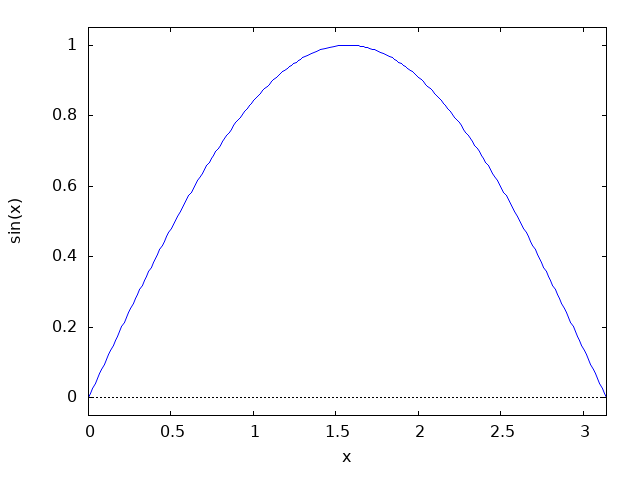

(%i5) plot2d(sin(x), [x, -%pi, %pi]);
(%o5) gráfico:



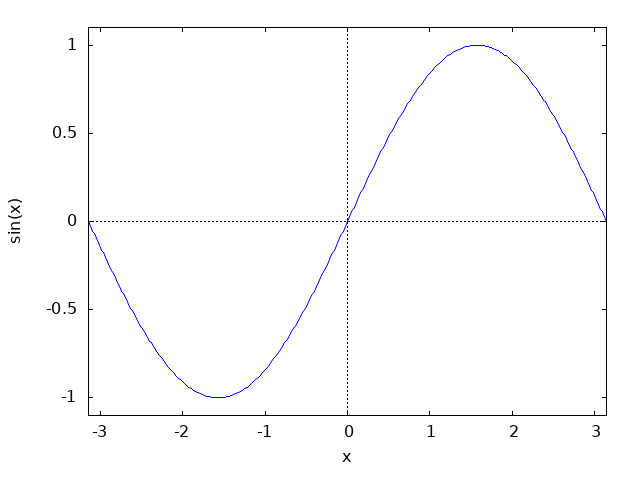

In [7]:
# Ejemplo con estado y gráfico
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    "plot2d(sin(x), [x, 0, %pi])",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

# Subida a GitHub 

Tenemos que ir a la  carpeta Maxima-Macro-jl

Pasos y estructura de subida a GitHub para que pueda ser instalado como paquete Julia

con o sin registro en Julia Registry. 

<img src="./images/arbolMaximaMacro.PNG" />

Debido a que ya está subida esta versión y **no queremos deshacernos de ella**, haremos una  versión o release de manera que despues de 

modificar los ficheros de la primera, se subirá como una segunda release conservando ambas. 

https://chat.qwen.ai/c/c9571681-83cc-445a-95d1-cc1a8f52e3d1

## Crear una estructura de manera automática

    - $julia --project=@. -e 'using Pkg; Pkg.generate("MaximaMacro")'

Con este comando se crea una estructura con estos componentes: 

<img src="./images/estructuraAutomatica.PNG" />

Pero nosotros ya tenemos creada una estructura. 

<img src="./images/arbolMaximaMacro.PNG" />

## Modificar los archivos necesarios y subirlo como una nueva release
Solo modificamos los archivos de la estructura existente de la anterior release y la subimos como una release nueva. 

### LICENSE
Copiamos dentro la licencia genérica

https://choosealicense.com/licenses/gpl-3.0/



### UUID en Julia

Un UUID (Identificador Único Universal) es un código alfanumérico de 128 bits que se usa para 

identificar de manera única objetos en un sistema informático y evitar duplicados. Su principal 

aplicación en el ámbito fiscal es para identificar de forma única una factura electrónica, como el 

Folio Fiscal, que garantiza su validez ante la autoridad tributaria. 

Para obtenerlo, desde Julia, ejecutamos:  

    - using Pkg

    - Pkg.generate("TempPkg")

    - # Copia el uuid del archivo Project.toml generado

    - rm("TempPkg", recursive=true)

Para obtener el dates: 

    - Base.identify_package("Dates")




In [ ]:
using Pkg

Pkg.generate("TempPkg")

  Generating  project TempPkg:
    TempPkg/Project.toml
    TempPkg/src/TempPkg.jl


Dict{String, Base.UUID} with 1 entry:
  "TempPkg" => UUID("94002945-a687-49bf-ad87-71bdff4e58e6")

In [ ]:
Base.identify_package("Dates")

Dates [ade2ca70-3891-5945-98fb-dc099432e06a]

### Project.toml
Cambiamos la versión y no cambiamos el uuid generado para la primera release. 

version = "2.0.0"  en lugar de 1.0.0 

Usamos el versionado semántico siguiente:

MAJOR (2.0.0): cambios incompatibles.

MINOR (1.1.0): funcionalidades nuevas, compatibles.

PATCH (1.0.1): correcciones de bugs.


###  README, demo.jl y demo_with_qinf.jl, gitignore

Ponemos los ejemplos adecuados a la última versión. 

## Comandos GitHub

    - git add .

    - git commit -m "feat: comandos entre comillas, compatibilidad total con maximma"

### Creamos nueva etiqueta

    - git tag -a v2.0.0 -m "Versión 2.0.0" 

### Subimos los cambios y la nueva etiqueta

    - git push origin main

    - git push origin v2.0.0

## Vamos a la página web y asignamos release 2

Para ello editamos desde la web el apartado Releases 

<img src="./images/releases.PNG" />

Lo editamos y cambiamos la versión creada y rellenamos todos los campos 

<img src="./images/editarReleases.PNG" />

## Registrar el paquete en Julia Registry 

🔁 Pasos para registrar
**Paso 1:**  Instalar JuliaRegistries/Registrator.jl
Ve a tu repositorio en GitHub → Settings → Webhooks → Add webhook:

Payload URL: https://juliahub.com/registrator/webhook
Content type: application/json
Secret: (deja vacío)
Events: selecciona "Let me select individual events" → marca "Create" (para tags/releases).
✅ Alternativa más fácil: instala la App de Registrator en tu cuenta de GitHub.


**Otra forma**: Crear una Release en GitHub

Ve a Releases → Draft a new release

Etiqueta: v2.0.0

Marca: "This is a pre-release" si es necesario, o no.

En la descripción, añade un comentario especial al final:

    @JuliaRegistrator register

⚠️ Esto activa el bot de registro automáticamente.

Paso 3: El bot hace el resto

El bot @JuliaRegistrator abrirá un Pull Request en el repositorio General.

Revisores humanos lo comprobarán (normalmente en 1-3 días).

Si todo está bien, se fusiona y tu paquete está registrado.

<img src="./images/releaseRegister.PNG" />

# Cómo cargar MaximaMacro desde Julia

## Con un include

In [1]:
# Cargar el módulo directamente desde el archivo
# Se carga la última versión que es MaximaMacro2. MaximaMacro.jl se ha  dejado
# para que funcionen los ejemplos de la otra versión. Quizás  se retome. 
include("MaximaMacro2.jl")


Main.MaximaMacro

(%i1) a: 5;
(%o1) 5

(%i2) b: 7;
(%o2) 7

(%i3) c: a + b;
(%o3) 12

(%i4) integrate(x^2, x);
(%o4) x^3/3

(%i5) plot2d(sin(x), [x, 0, %pi]);
(%o5) gráfico:



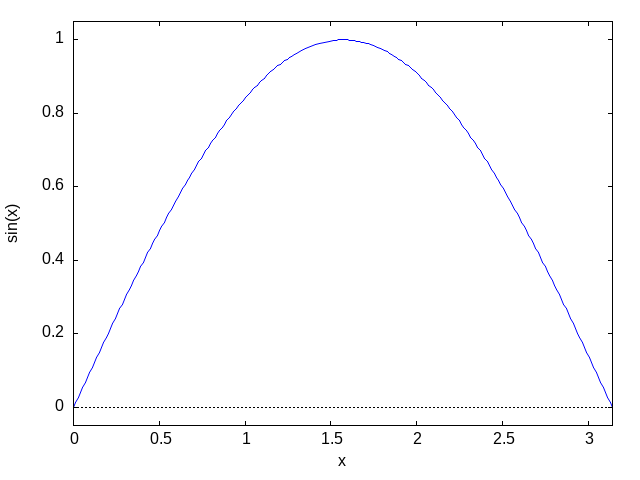

In [2]:

# Usar el módulo (importarlo al espacio de nombres)
using .MaximaMacro

# Ejemplo de uso
@maxima_cell_session(
    "a: 5",
    "b: 7",
    "c: a + b",
    "integrate(x^2, x);",
    "plot2d(sin(x), [x, 0, %pi]);"
)

## Desde GitHub sin Registry en Julia

Desde línea de comandos

    - $julia

    - ] <--para entrar en modo paquetes

    - add add https://github.com/imardiego/MaximaMacro-jl.git

<img src="./images/compilarJuliayMacro.PNG" />

Aquí nos dice que ya está compilada. 


## Desde GitHub con Registry en Julia

Desde línea de comandos

    - $julia
    - ]  <-- para entrar en modo paquetes
    - add MaximaMacro


Esta no la podremos probar hasta que la aprueben. 



Resumen de las formas de incluir instalar o hacer uso de MaximaMacro

<img src="./images/resumen llamadas a maximamacro.PNG"/>

# Latex: como hacer para que Markdown interprete latex

**Activar soporte Markdown + LaTeX**

**!!! Seguir indagando en esto !!!**

En las celdas de tipo Markdown de tu notebook, puedes usar sintaxis LaTeX estándar:

Tipo de ecuación -->	       Sintaxis	    -->                 Ejemplo renderizado

En línea	\$ ... \$	-->       \$\alpha + \beta = \gamma\$ -->   𝛼 + 𝛽 = 𝛾 

En bloque	\$\$ ... \$\$	

En resumen, basta en línea con encerrar el texto de Latex entre $ y con dobles $$ cuando es un bloque. 
